In [1]:
%load_ext autoreload
# import datetime
# import ete3
# import itertools
import json
import logging
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import os
import pandas as pd
import typing
# import re
# import xml.etree.ElementTree as ET
# import xml.dom.minidom
# import xmlschema
import pm4py

In [3]:
%autoreload
from maxes.xes_loader2 import XesLoader
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
import maxes.utils
from maxes.analyze_xes import AnalyzeXes

In [ ]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

In [5]:
log1 = pm4py.read_xes("../data/other/event_log.xes")
log1

parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


,Payment type,Products,instance,concept:name,Order ID,action,model,lifecycle:transition,type,time:timestamp,Customer type,case:concept:name,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,Credit,"[laptop,phone,laptop,desktop]",1,,1.0,Receive customer order,Order,complete,Order,2024-01-01 00:02:57+00:00,Silver,,NaN,NaN,NaN,NaN,NaN,NaN
1,Plan,"[laptop,desktop]",2,,2.0,Receive customer order,Order,complete,Order,2024-01-01 00:14:11+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
2,Credit,"[laptop,phone,laptop,desktop]",1,,1.0,Try payment,Order,complete,Order,2024-01-01 00:14:11+00:00,Silver,,NaN,NaN,NaN,NaN,NaN,NaN
3,Plan,"[laptop,desktop]",2,,2.0,Deny order,Order,complete,Order,2024-01-01 00:16:01+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
4,Credit,[phone],3,,3.0,Receive customer order,Order,complete,Order,2024-01-01 00:16:01+00:00,Gold,,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,Plan,"[tv,desktop]",2970,,2970.0,Complete packing,Order,complete,Order,2024-01-31 23:50:39+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31251,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31252,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31253,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
log_processed = (
    log1
    .drop(columns=['case:concept:name', 'concept:name'])
    .rename(columns={'instance': 'case:concept:name', 'action': 'concept:name'})
    .sort_values(by=['case:concept:name', 'time:timestamp'])
    .reset_index(drop=True)
)

def reorder_xes_columns(df: pd.DataFrame):
    special_columns = ['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']

    df_special_columns = [column for column in special_columns if column in df.columns]
    df_other_columns = [column for column in df.columns if column not in special_columns]
    new_columns = df_special_columns + df_other_columns

    return df[new_columns]

# reorder columns
log_processed = reorder_xes_columns(log_processed)

log_processed

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2024-01-01 00:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2024-01-01 00:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,2998,Process order,complete,2024-01-31 23:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
log_processed['case:concept:name'].nunique()

2999

In [126]:
log_processed.columns

Index(['case:concept:name', 'concept:name', 'lifecycle:transition',
       'time:timestamp', 'Payment type', 'Products', 'Order ID', 'model',
       'type', 'Customer type', 'Number of orders', 'Shipment ID', 'Courier',
       'Amount', 'Replenishment ID', 'Product'],
      dtype='object')

In [ ]:
# generation_frequency: per_case | per_event
# values: callable | random_categorical | random_range | ...
# nullable: {
#   dependent: list[str]
# }
{
    'case:concept:name': '',
    'concept:name': '',
    'lifecycle:transition': '',
    'time:timestamp': '',
    'Payment type': {
        'type': 'one_per_case',
        'values': 'analyze', # default
        'nullable': {
            'dependent': ['concept:name']
        }
    },
    'Products': {
        'type': 'once_per_case',
        'values': generate_Products,
        'nullable': {
            'dependent': ['concept:name']
        }
    },
    'Order ID': {
        # copy from concept:name
    },
    'model': {
        'type': 'predict',
        'depedent': ['concept:name']
    },
    'type': {}, # same as model
    'Customer type': {
        'type': 'once_per_case',
        'values': 'analyze', # default
        'nullable': {
            'dependent': ['concept:name']
        }
    },
    'Number of orders': {
        'type': 'once_per_case',
        'values': 'analyze',
        'nullable': {
            'dependent': ['concept:name']
        }
    },
    'Shipment ID'
    'Courier',
    'Amount'
    'Replenishment ID'
    'Product'
}

# skip

In [114]:
l = [str(row['concept:name']) + ' | ' + str(row['model']) for i, row in log_processed[['concept:name', 'model']].iterrows()]
len(l)

31255

In [117]:
# next(log_processed[['concept:name', 'model']].iterrows())[1]['concept:name']
log_processed[(log_processed['concept:name'] == 'Deliver order') & (log_processed['model'] == 'Order')]

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
23,1,Deliver order,complete,2024-01-01 15:49:25+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
46,3,Deliver order,complete,2024-01-01 05:05:47+00:00,Credit,[phone],3.0,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN
78,4,Deliver order,complete,2024-01-01 18:29:45+00:00,Credit,"[tv,desktop,tv]",4.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
89,5,Deliver order,complete,2024-01-01 04:55:55+00:00,Credit,"[tv,tv,laptop]",5.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
114,6,Deliver order,complete,2024-01-01 04:25:43+00:00,Plan,"[phone,phone,phone]",6.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31091,2972,Deliver order,complete,2024-01-31 23:27:02+00:00,Plan,"[laptop,laptop]",2972.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31101,2973,Deliver order,complete,2024-01-31 21:04:59+00:00,Credit,"[tv,laptop,phone]",2973.0,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN
31121,2976,Deliver order,complete,2024-01-31 21:35:03+00:00,Debit,"[phone,phone]",2976.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
31135,2978,Deliver order,complete,2024-01-31 21:14:50+00:00,Plan,[tv],2978.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
from collections import Counter

Counter(l)

Counter({'Pick inventory | Order': 5018,
         'Receive customer order | Order': 2999,
         'Try payment | Order': 2790,
         'Receive payment | Order': 2670,
         'Process order | Order': 2670,
         'Pack order | Order': 2653,
         'Complete packing | Order': 2652,
         'Deliver order | Shipment': 2640,
         'Deliver order | Order': 2640,
         'Pick backorder | Order': 1661,
         'Load products | Shipment': 375,
         'Start shipment | Shipment': 374,
         'Create shipment | Shipment': 372,
         'Complete shipment | Shipment': 371,
         'Retry payment | Order': 258,
         'Update payment type | Order': 244,
         'Deny order | Order': 208,
         'Create replenishment order | Replenishment': 182,
         'Cancel order | Order': 120,
         'Order product | Replenishment': 119,
         'Receive replenishment | Replenishment': 118,
         'Process replenishment | Replenishment': 118,
         'Change courier | Shipment'

Test:

concept:name -> model, type

concept:name -> payment type (existence of value)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

def create_model(input_columns: list[str]):
    transformers = [(column, OneHotEncoder(), [column]) for column in input_columns]
    column_transformer = ColumnTransformer(transformers)
    pipeline = Pipeline(steps=[
        ("column selector", column_transformer),
        ("classifier", MLPClassifier())
    ])
    return pipeline

class CategoricalPredictor():
    def __init__(self):
        pass

    def fit(self, X: list[list[str]], y: list[str]):
        self.encoders_ = [OneHotEncoder() for i in range(X.shape[1])]

        for encoder in self.encoders_:
            encoder.fit(X[0:])


        transformers = [(column, OneHotEncoder(), [column]) for column in input_columns]
        column_transformer = ColumnTransformer(transformers)

        self.pipeline_ = Pipeline(steps=[
            ("column selector", column_transformer),
            ("classifier", MLPClassifier())
        ])
        return self

In [118]:
from sklearn.model_selection import train_test_split

df = log_processed

X = df[['concept:name']]
y = df[['model']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23441, 1) (23441, 1) (7814, 1) (7814, 1)


In [125]:
y.value_counts()

model        
Order            26583
Shipment          4135
Replenishment      537
Name: count, dtype: int64

In [119]:
n_in_classes = X.nunique()
print(f"{n_in_classes=}")
n_out_classes = y.nunique()
print(f"{n_out_classes=}")

n_in_classes=concept:name    22
dtype: int64
n_out_classes=model    3
dtype: int64


In [ ]:
model = Pipeline(steps=[
    ('one hot', OneHotEncoder()),
    ("classifier", MLPClassifier(hidden_layer_sizes=(11, 6)))
])

# model.fit(df[['concept:name']], df[['model']])
model.fit(X_train, y_train)

In [121]:
len(model.steps[0][1].categories_[0])

22

In [122]:
n_layers = model.steps[1][1].n_layers_
print(f"{n_layers=}")
hidden_layer_sizes = model.steps[1][1].hidden_layer_sizes
print(f"{hidden_layer_sizes=}")

n_layers=4
hidden_layer_sizes=(11, 6)


In [123]:
y_pred = model.predict(X_test)

In [124]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.9148963399027387


array([[6636,    0,    0],
       [   0,  140,    0],
       [ 665,    0,  373]])

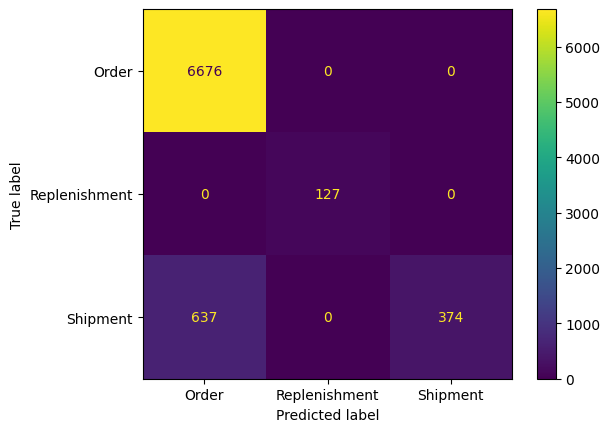

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=model.classes_)
disp.plot()

In [54]:
OneHotEncoder().fit_transform([['a', '1'], ['b', '1'], ['c', '2']]).toarray()

array([[1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.]])

In [15]:
df = log_processed

# concept_name_oh = OneHotEncoder()
# X = concept_name_oh.fit_transform(df[['concept:name']])
X = df[['concept:name']]
X

,concept:name
0,Receive customer order
1,Try payment
2,Receive payment
3,Process order
4,Pick inventory
...,...
31250,Process order
31251,Pick inventory
31252,Pick inventory
31253,Pick inventory


In [13]:
# model_oh = OneHotEncoder()
# y = model_oh.fit_transform(df[['model']])
y = df[['model']]
y

,model
0,Order
1,Order
2,Order
3,Order
4,Order
...,...
31250,Order
31251,Order
31252,Order
31253,Order


In [16]:
model = MLPClassifier().fit(X, y)
model

ValueError: could not convert string to float: 'Receive customer order'

In [ ]:
print(output_transformer.transform([['Order']]).toarray())

In [38]:
model = create_model(input_columns=['concept:name'])
X = df[['concept:name']]

output_transformer = OneHotEncoder()
y = output_transformer.fit_transform(df[['model']])
model.fit(X, y)
tempdf = pd.DataFrame([['Create shipment']], columns=['concept:name'])
y_untransformed = model.predict(tempdf)
output_transformer.inverse_transform(y_untransformed)

array([['Shipment']], dtype=object)

In [ ]:
model = create_model(input_columns=['concept:name'])
X = df[['concept:name']]

y = df[['model']]
model.fit(X, y)
model.predict([['Try payment']])

# Correlation study

In [38]:
print("Customer type:", dict(log1['Customer type'].value_counts()))
print("Payment type:", dict(log1['Payment type'].value_counts()))

Customer type: {'Bronze': 8951, 'Gold': 8911, 'Silver': 8721}
Payment type: {'Credit': 8953, 'Debit': 8889, 'Plan': 8741}


In [62]:
testdf = (
    log1[['Customer type', 'Payment type']].dropna()
)
testdf

,Customer type,Payment type
0,Silver,Credit
1,Bronze,Plan
2,Silver,Credit
3,Bronze,Plan
4,Gold,Credit
...,...,...
31248,Silver,Debit
31250,Bronze,Plan
31251,Bronze,Plan
31252,Bronze,Plan


In [59]:
contingency_table = pd.crosstab(testdf['Customer type'], testdf['Payment type'])
contingency_table

Payment type,Credit,Debit,Plan
Customer type,,,
Bronze,3100,2894,2957
Gold,3116,2834,2961
Silver,2737,3161,2823


In [60]:
testdf[(testdf['Customer type'] == 'Gold') & (testdf['Payment type'] == 'Plan')].count()

Customer type    2961
Payment type     2961
dtype: int64

In [61]:
import scipy.stats as ss
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)

print(chi2)
print(p)
print(dof)
print(expected)
print(p < 0.05)

52.49707096378879
1.0857980254073538e-10
4
[[3014.64481059 2993.09479743 2943.26039198]
 [3001.17304292 2979.7193319  2930.10762517]
 [2937.18214648 2916.18587067 2867.63198285]]
True


In [9]:
log2 = pm4py.read_xes("../data/other/event_log_lifecyle_moves.xes")
log2

parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


,Payment type,Products,instance,concept:name,Order ID,action,model,lifecycle:transition,type,objectlifecycle:moves,time:timestamp,Customer type,case:concept:name,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,Credit,"[laptop,phone,laptop,desktop]",1,,1.0,Receive customer order,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-01 00:02:57+00:00,Silver,,NaN,NaN,NaN,NaN,NaN,NaN
1,Plan,"[laptop,desktop]",2,,2.0,Receive customer order,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-01 00:14:11+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
2,Credit,"[laptop,phone,laptop,desktop]",1,,1.0,Try payment,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-01 00:14:11+00:00,Silver,,NaN,NaN,NaN,NaN,NaN,NaN
3,Plan,"[laptop,desktop]",2,,2.0,Deny order,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-01 00:16:01+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
4,Credit,[phone],3,,3.0,Receive customer order,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-01 00:16:01+00:00,Gold,,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,Plan,"[tv,desktop]",2970,,2970.0,Complete packing,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-31 23:50:39+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31251,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31252,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN
31253,Plan,"[phone,tv,laptop,phone]",2998,,2998.0,Pick inventory,Order,complete,Order,"{'value': None, 'children': {'objectlifecycle:...",2024-01-31 23:56:07+00:00,Bronze,,NaN,NaN,NaN,NaN,NaN,NaN


# Null prediction

Goal: predict if data cell is null based on attributes

In [ ]:
# Payment type
# Products
# Order ID
# model

In [127]:
log_processed

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2024-01-01 00:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2024-01-01 00:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,2998,Process order,complete,2024-01-31 23:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
class NullabilityPredictor():
    def __init__(self, existing_value_marker='TBD'):
        self.existing_value_marker = existing_value_marker

    def fit(self, X, y):
        n_true, n_false = y.ifnull().value_counts()

        if n_true == 0:
            self.nullability_ = 'always'
            return
        elif n_false == 0:
            self.nullability_ = 'never'
            return

        self.model_ = Pipeline(steps=[
            ('OneHotEncoder', OneHotEncoder()),
            ("MLPClassifier", MLPClassifier())
        ])
        self.model_.fit(X, y)

        return self

    def predict(self, X):
        if self.nullability_ == 'always':
            return pd.Series((None for i in range(X.shape[0])))
        elif self.nullability_ == 'never':
            return pd.Series((self.existing_value_marker for i in range(X.shape[0])))

        y = self.model_.predict(X)


In [161]:
a = df['model'].notnull().value_counts()
# a[False]
a.get(False) or 0

0

In [141]:
X = df['concept:name']
# X = df[['concept:name']]
print(X.__class__)
print(X.shape)

y = df['Payment type'].notnull()
print(y.__class__)
print(y.shape)
y

<class 'pandas.core.series.Series'>
(31255,)
<class 'pandas.core.series.Series'>
(31255,)


0        True
1        True
2        True
3        True
4        True
         ... 
31250    True
31251    True
31252    True
31253    True
31254    True
Name: Payment type, Length: 31255, dtype: bool

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
class FakePredictor:
    def __init__(self, value):
        self.value = value

    def fit(self): return self

    def predict(self, X):
        return np.repeat(True, X.shape[0])

In [233]:
class FullModel:
    def __init__(self):
        pass

    def fit(self, df):
        special_attributes = ['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']
        special_attributes = [attr for attr in special_attributes if attr in df.columns]
        other_attributes = [attr for attr in df.columns if attr not in special_attributes]

        self.attribute_presence_models_per_attribute_ = {}
        for attribute in other_attributes:
            model = self._fit_presence_model(df, attribute)
            self.attribute_presence_models_per_attribute_[attribute] = model

        return self

    def sample(self, n: int):
        pass

    def _fit_presence_model(self, df: pd.DataFrame, attribute: str):
        print(attribute)
        y = df[attribute].notnull()

        value_counts = y.value_counts()
        n_true = value_counts.get(True) or 0
        n_false = value_counts.get(False) or 0

        if n_true == 0:
            return FakePredictor(value=False)
        if n_false == 0:
            return FakePredictor(value=True)

        X = df[['concept:name']]

        model = Pipeline(steps=[
            ('OneHotEncoder', OneHotEncoder()),
            ("MLPClassifier", MLPClassifier())
        ])

        model.fit(X, y)
        return model

    def _predict_attributes_presence(self, df: pd.DataFrame):
        for attribute in self.attribute_presence_models_per_attribute_.keys():
            # print(attribute)
            df[attribute] = self._predict_attribute_presence(df, attribute)

        return df

    def _predict_attribute_presence(self, df: pd.DataFrame, attribute: str):
        model = self.attribute_presence_models_per_attribute_[attribute]

        X = df[['concept:name']]
        return model.predict(X)


In [234]:
X_train, X_test = train_test_split(log_processed)

X_train = X_train.copy()
X_test = X_test.copy()

print(X_train.shape)
print(X_test.shape)

(23441, 16)
(7814, 16)


In [235]:
full_model = FullModel()
full_model.fit(X_train)

Payment type
Products
Order ID
model
type
Customer type
Number of orders
Shipment ID
Courier
Amount
Replenishment ID
Product


In [236]:
y_test = X_test.copy()

y_test['Payment type'] = X_test['Payment type'].notnull()
y_test['Products'] = X_test['Products'].notnull()
y_test['Order ID'] = X_test['Order ID'].notnull()
y_test['model'] = X_test['model'].notnull()
y_test['type'] = X_test['type'].notnull()
y_test['Customer type'] = X_test['Customer type'].notnull()
y_test['Number of orders'] = X_test['Number of orders'].notnull()
y_test['Shipment ID'] = X_test['Shipment ID'].notnull()
y_test['Courier'] = X_test['Courier'].notnull()
y_test['Amount'] = X_test['Amount'].notnull()
y_test['Replenishment ID'] = X_test['Replenishment ID'].notnull()
y_test['Product'] = X_test['Product'].notnull()

y_test

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
14876,1139,Receive customer order,complete,2024-01-12 14:39:08+00:00,True,True,True,True,True,True,False,False,False,False,False,False
6771,306,Process order,complete,2024-01-03 22:38:51+00:00,True,True,True,True,True,True,False,False,False,False,False,False
1104,48,Deliver order,complete,2024-01-04 23:51:49+00:00,False,False,False,True,True,False,True,True,True,False,False,False
18485,1542,Receive customer order,complete,2024-01-16 20:41:28+00:00,True,True,True,True,True,True,False,False,False,False,False,False
13661,1001,Pick inventory,complete,2024-01-11 02:33:39+00:00,True,True,True,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30820,2941,Update payment type,complete,2024-01-31 07:27:34+00:00,True,True,True,True,True,True,False,False,False,False,False,False
29451,2784,Receive payment,complete,2024-01-29 19:25:10+00:00,True,True,True,True,True,True,False,False,False,False,False,False
27823,2595,Deliver order,complete,2024-01-28 11:23:16+00:00,True,True,True,True,True,True,False,False,False,False,False,False
11061,708,Receive customer order,complete,2024-01-07 21:37:15+00:00,True,True,True,True,True,True,False,False,False,False,False,False


In [237]:
y_pred = full_model._predict_attributes_presence(X_test.copy())
y_pred

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
14876,1139,Receive customer order,complete,2024-01-12 14:39:08+00:00,True,True,True,True,True,True,False,False,False,False,False,False
6771,306,Process order,complete,2024-01-03 22:38:51+00:00,True,True,True,True,True,True,False,False,False,False,False,False
1104,48,Deliver order,complete,2024-01-04 23:51:49+00:00,False,False,False,True,True,False,True,True,True,False,False,False
18485,1542,Receive customer order,complete,2024-01-16 20:41:28+00:00,True,True,True,True,True,True,False,False,False,False,False,False
13661,1001,Pick inventory,complete,2024-01-11 02:33:39+00:00,True,True,True,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30820,2941,Update payment type,complete,2024-01-31 07:27:34+00:00,True,True,True,True,True,True,False,False,False,False,False,False
29451,2784,Receive payment,complete,2024-01-29 19:25:10+00:00,True,True,True,True,True,True,False,False,False,False,False,False
27823,2595,Deliver order,complete,2024-01-28 11:23:16+00:00,False,False,False,True,True,False,True,True,True,False,False,False
11061,708,Receive customer order,complete,2024-01-07 21:37:15+00:00,True,True,True,True,True,True,False,False,False,False,False,False


In [238]:
print('Payment type:     ', accuracy_score(y_test['Payment type'], y_pred['Payment type']))
print('Products:         ', accuracy_score(y_test['Products'], y_pred['Products']))
print('Order ID:         ', accuracy_score(y_test['Order ID'], y_pred['Order ID']))
print('model:            ', accuracy_score(y_test['model'], y_pred['model']))
print('type:             ', accuracy_score(y_test['type'], y_pred['type']))
print('Customer type:    ', accuracy_score(y_test['Customer type'], y_pred['Customer type']))
print('Number of orders: ', accuracy_score(y_test['Number of orders'], y_pred['Number of orders']))
print('Shipment ID:      ', accuracy_score(y_test['Shipment ID'], y_pred['Shipment ID']))
print('Courier:          ', accuracy_score(y_test['Courier'], y_pred['Courier']))
print('Amount:           ', accuracy_score(y_test['Amount'], y_pred['Amount']))
print('Replenishment ID: ', accuracy_score(y_test['Replenishment ID'], y_pred['Replenishment ID']))
print('Product:          ', accuracy_score(y_test['Product'], y_pred['Product']))

Payment type:      0.9152802661888917
Products:          0.9152802661888917
Order ID:          0.9152802661888917
model:             1.0
type:              1.0
Customer type:     0.9152802661888917
Number of orders:  0.9152802661888917
Shipment ID:       0.9152802661888917
Courier:           0.9152802661888917
Amount:            1.0
Replenishment ID:  1.0
Product:           1.0


array([False,  True])

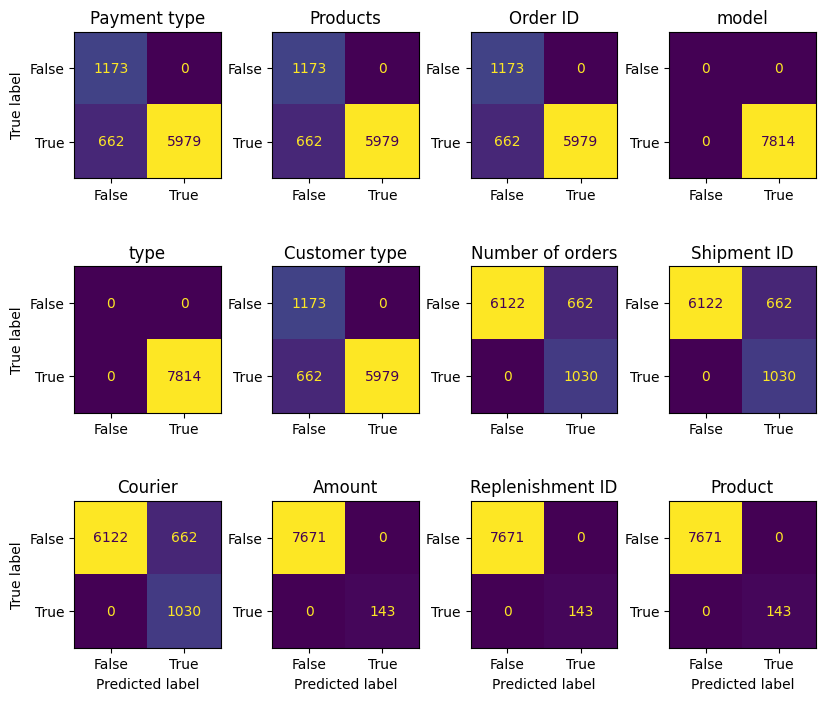

In [270]:

fig, axs = plt.subplots(3, 4)
fig.set_size_inches(10, 8)
fig.subplots_adjust(hspace=0.6, wspace=0.1)

# axs = axs.flatten()

attributes = list(full_model.attribute_presence_models_per_attribute_.keys())

labels = full_model.attribute_presence_models_per_attribute_['Payment type'].classes_

for i, i_axs in enumerate(axs):
    for j, ax in enumerate(i_axs):
        index = i * len(i_axs) + j
        attribute = attributes[index]
        ax.set_title(attribute)

        i_y_test = y_test[attribute]
        i_y_pred = y_pred[attribute]

        conf = confusion_matrix(i_y_test, i_y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(conf, display_labels=labels)
        disp.plot(ax=ax)
        disp.im_.colorbar.remove()
        if i < 2:
            disp.ax_.set_xlabel('')
        if j != 0:
            disp.ax_.set_ylabel('')

In [166]:
log_processed

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2024-01-01 00:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2024-01-01 00:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,2998,Process order,complete,2024-01-31 23:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
log_processed['Payment type'].value_counts()

Payment type
Credit    8953
Debit     8889
Plan      8741
Name: count, dtype: int64

# Full model

In [271]:
log_processed

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
0,1,Receive customer order,complete,2024-01-01 00:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Process order,complete,2024-01-01 00:24:14+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31250,2998,Process order,complete,2024-01-31 23:16:24+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31251,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31252,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
31253,2998,Pick inventory,complete,2024-01-31 23:56:07+00:00,Plan,"[phone,tv,laptop,phone]",2998.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
nunique_per_case = log_processed.groupby('case:concept:name').nunique()
nunique_per_case

,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
case:concept:name,,,,,,,,,,,,,,,
1,17,1,22,1,1,1,3,3,1,1,1,1,1,1,1
2,11,1,15,1,1,1,3,3,1,1,1,1,1,1,1
3,16,1,21,1,1,1,3,3,1,1,1,1,1,1,1
4,14,1,19,1,1,1,3,3,1,1,1,1,1,1,1
5,13,1,23,1,1,1,3,3,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5,1,5,1,1,1,1,1,1,0,0,0,0,0,0
2996,5,1,5,1,1,1,1,1,1,0,0,0,0,0,0
2997,4,1,4,1,1,1,1,1,1,0,0,0,0,0,0


In [277]:
# model, type, customer type
# null, then once per case: Courier, Amount, Replenishment ID, Product ??, Shipment ID, ...

# Count different values per case
# for column in nunique_per_case.columns:
#     vc = nunique_per_case[column].value_counts()
#     print("Column: ", column)
#     print(vc)
print("Columns that only have one value per case")
for column in nunique_per_case.columns:
    value_counts = nunique_per_case[column].value_counts()
    if len(value_counts) > 1:
        continue
    print(column)

Columns that only have one value per case
lifecycle:transition
Products
Order ID
Customer type


In [279]:
# build simple random weighted generation model

first_per_case = log_processed.groupby('case:concept:name').first()
first_per_case

,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
case:concept:name,,,,,,,,,,,,,,,
1,Receive customer order,complete,2024-01-01 00:02:57+00:00,Credit,"[laptop,phone,laptop,desktop]",1.0,Order,Order,Silver,5.0,1.0,Courier C,14.0,1.0,desktop
2,Receive customer order,complete,2024-01-01 00:14:11+00:00,Plan,"[laptop,desktop]",2.0,Order,Order,Bronze,5.0,2.0,Courier C,26.0,2.0,desktop
3,Receive customer order,complete,2024-01-01 00:16:01+00:00,Credit,[phone],3.0,Order,Order,Gold,5.0,3.0,Courier C,25.0,3.0,desktop
4,Receive customer order,complete,2024-01-01 00:31:56+00:00,Credit,"[tv,desktop,tv]",4.0,Order,Order,Bronze,5.0,4.0,Courier C,71.0,4.0,phone
5,Receive customer order,complete,2024-01-01 00:39:48+00:00,Credit,"[tv,tv,laptop]",5.0,Order,Order,Silver,10.0,5.0,Courier B,68.0,5.0,tv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Receive customer order,complete,2024-01-31 22:33:38+00:00,Plan,"[phone,desktop]",2995.0,Order,Order,Bronze,NaN,NaN,None,NaN,NaN,None
2996,Receive customer order,complete,2024-01-31 22:45:55+00:00,Credit,"[tv,phone,laptop,laptop]",2996.0,Order,Order,Gold,NaN,NaN,None,NaN,NaN,None
2997,Receive customer order,complete,2024-01-31 22:52:45+00:00,Credit,[laptop],2997.0,Order,Order,Bronze,NaN,NaN,None,NaN,NaN,None


In [281]:
dict(first_per_case['Customer type'].value_counts())

{'Bronze': 1015, 'Gold': 1000, 'Silver': 984}

In [295]:
labels, counts = np.unique([1, 2, 2, 2, 2], return_counts=True)
dict(zip(list(labels), list(counts)))

{1: 1, 2: 4}

In [299]:
import maxes.utils

class WeightedSampler:

    def fit(self, X: np.array):
        labels, counts = np.unique(X, return_counts=True)
        self.weights_ = dict(zip(list(labels), list(counts)))
        return self

    def sample(self, n=1):
        return maxes.utils.choices(self.weights_, n)

sampler = WeightedSampler().fit(first_per_case['Customer type'])
sampler.sample(10)

# weights = dict(first_per_case['Customer type'].value_counts())
# maxes.utils.choices(weights, 10)

['Bronze',
 'Silver',
 'Silver',
 'Gold',
 'Silver',
 'Gold',
 'Gold',
 'Bronze',
 'Bronze',
 'Gold']

In [365]:
class FullModel:
    def __init__(self, config):
        self.config = config

    def fit(self, df):
        special_attributes = ['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']
        self.special_attributes_ = [attr for attr in special_attributes if attr in df.columns]
        self.other_attributes_ = [attr for attr in df.columns if attr not in special_attributes]

        # Presence models (predict null / not null)
        self.attribute_presence_models_per_attribute_ = {}
        for attribute in self.other_attributes_:
            model = self._fit_presence_model(df, attribute)
            self.attribute_presence_models_per_attribute_[attribute] = model

        first_values_per_case = df.groupby('case:concept:name').first()
        self.per_case_samplers_ = {}
        for attribute, attribute_config in self.config['attributes'].items():
            frequency_type = attribute_config['frequency_type']
            if frequency_type == 'per_case':
                model = attribute_config['model']
                X = first_values_per_case[attribute].to_numpy()
                model.fit(X)
                self.per_case_samplers_[attribute] = model
            else:
                raise ValueError(f"Unknown frequency_type: {frequency_type}")

        return self

    def sample(self, n: int):
        pass

    def predict(self, df: pd.DataFrame):
        df = df.copy()
        self._predict_attributes_presence(df)

        cases_count = df['case:concept:name'].nunique()
        print(cases_count)
        for attribute, model in self.per_case_samplers_.items():
            generated_values = model.sample(cases_count)
            i = 0
            result_df_parts = []
            for index, group in df[df[attribute] == True].groupby('case:concept:name'):
                group[attribute] = generated_values[i]
                result_df_parts.append(group)
                print(i)

                i += 1
            df = pd.concat(result_df_parts).sort_index()
            # i = 0
            # def apply(group):
            #     nonlocal i
            #     group[attribute] = result[i]
            #     i += 1
            #     return group
            # df[df[attribute] == True].groupby('case:concept:name').apply(apply)
            # for index, group in df[df[attribute] == True].groupby('case:concept:name'):
            #     print(len(group))
            #     group[attribute] = result[i]
            #     i += 1

        return df

    def _fit_presence_model(self, df: pd.DataFrame, attribute: str):
        print(attribute)
        y = df[attribute].notnull()

        value_counts = y.value_counts()
        n_true = value_counts.get(True) or 0
        n_false = value_counts.get(False) or 0

        if n_true == 0:
            return FakePredictor(value=False)
        if n_false == 0:
            return FakePredictor(value=True)

        X = df[['concept:name']]

        model = Pipeline(steps=[
            ('OneHotEncoder', OneHotEncoder()),
            ("MLPClassifier", MLPClassifier())
        ])

        model.fit(X, y)
        return model

    def _predict_attributes_presence(self, df: pd.DataFrame):
        for attribute in self.attribute_presence_models_per_attribute_.keys():
            # print(attribute)
            df[attribute] = self._predict_attribute_presence(df, attribute)

        return df

    def _predict_attribute_presence(self, df: pd.DataFrame, attribute: str):
        model = self.attribute_presence_models_per_attribute_[attribute]

        X = df[['concept:name']]
        return model.predict(X)

    def _find_columns_with_single_value_per_case(self, df: pd.DataFrame):
        nunique_per_case = df.groupby('case:concept:name').nunique()

        return [column
                for column in nunique_per_case.columns
                if column in self.other_columns_ and len(nunique_per_case[column].value_counts()) == 1]

In [308]:
class IdGenerator():
    def fit(self, _X):
        self.id_ = 0
        return self
    def sample(self, n=1):
        result = [self.id_ + i for i in range(n)]
        self.id_ += n
        return result


In [366]:
config = {
    'attributes': {
        'Order ID': {
            'frequency_type': 'per_case',
            'model': IdGenerator()
        },
        'Products': {
            'frequency_type': 'per_case',
            'model': WeightedSampler()
        },
        'Customer type': {
            'frequency_type': 'per_case',
            'model': WeightedSampler()
        }
    }
}

full_model = FullModel(config)
full_model.fit(log_processed[['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp', 'Order ID', 'Products', 'Customer type']])

Order ID
Products
Customer type


In [370]:
X_test

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
14876,1139,Receive customer order,complete,2024-01-12 14:39:08+00:00,Credit,"[laptop,tv,laptop]",1139.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
6771,306,Process order,complete,2024-01-03 22:38:51+00:00,Debit,[desktop],306.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
1104,48,Deliver order,complete,2024-01-04 23:51:49+00:00,NaN,NaN,NaN,Shipment,Shipment,NaN,10.0,48.0,Courier B,NaN,NaN,NaN
18485,1542,Receive customer order,complete,2024-01-16 20:41:28+00:00,Plan,"[tv,desktop,phone]",1542.0,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN
13661,1001,Pick inventory,complete,2024-01-11 02:33:39+00:00,Debit,"[laptop,laptop]",1001.0,Order,Order,Bronze,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30820,2941,Update payment type,complete,2024-01-31 07:27:34+00:00,Plan,"[desktop,tv]",2941.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
29451,2784,Receive payment,complete,2024-01-29 19:25:10+00:00,Debit,"[laptop,tv,desktop,phone]",2784.0,Order,Order,Silver,NaN,NaN,NaN,NaN,NaN,NaN
27823,2595,Deliver order,complete,2024-01-28 11:23:16+00:00,Credit,"[tv,desktop,phone]",2595.0,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN
11061,708,Receive customer order,complete,2024-01-07 21:37:15+00:00,Debit,"[phone,phone,desktop]",708.0,Order,Order,Gold,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
# full_model.per_case_samplers_['Customer type'].sample()
temp_X_test = X_test[['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']].copy()
df = full_model.predict(temp_X_test)
df

2671
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Order ID,Products,Customer type
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,2671,[desktop],Gold
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,2671,[desktop],Gold
3,1,Process order,complete,2024-01-01 00:24:14+00:00,2671,[desktop],Gold
6,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,2671,[desktop],Gold
42,3,Process order,complete,2024-01-01 00:41:47+00:00,2673,"[tv,desktop,tv,desktop]",Silver
...,...,...,...,...,...,...,...
31219,2992,Receive payment,complete,2024-01-31 21:49:19+00:00,5333,"[tv,tv]",Silver
31226,2993,Pick inventory,complete,2024-01-31 22:43:47+00:00,5334,"[phone,phone,tv]",Gold
31236,2995,Pick inventory,complete,2024-01-31 23:16:37+00:00,5335,[tv],Gold
31241,2996,Pick inventory,complete,2024-01-31 23:42:47+00:00,5336,"[phone,phone,tv,phone]",Bronze


In [369]:
df.sort_values(by=['case:concept:name', 'time:timestamp'])

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Order ID,Products,Customer type
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,2671,[desktop],Gold
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,2671,[desktop],Gold
3,1,Process order,complete,2024-01-01 00:24:14+00:00,2671,[desktop],Gold
6,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,2671,[desktop],Gold
42,3,Process order,complete,2024-01-01 00:41:47+00:00,2673,"[tv,desktop,tv,desktop]",Silver
...,...,...,...,...,...,...,...
31219,2992,Receive payment,complete,2024-01-31 21:49:19+00:00,5333,"[tv,tv]",Silver
31226,2993,Pick inventory,complete,2024-01-31 22:43:47+00:00,5334,"[phone,phone,tv]",Gold
31236,2995,Pick inventory,complete,2024-01-31 23:16:37+00:00,5335,[tv],Gold
31241,2996,Pick inventory,complete,2024-01-31 23:42:47+00:00,5336,"[phone,phone,tv,phone]",Bronze


In [331]:
df = X_test[['case:concept:name', 'concept:name', 'lifecycle:transition', 'time:timestamp']].copy()
df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp
14876,1139,Receive customer order,complete,2024-01-12 14:39:08+00:00
6771,306,Process order,complete,2024-01-03 22:38:51+00:00
1104,48,Deliver order,complete,2024-01-04 23:51:49+00:00
18485,1542,Receive customer order,complete,2024-01-16 20:41:28+00:00
13661,1001,Pick inventory,complete,2024-01-11 02:33:39+00:00
...,...,...,...,...
30820,2941,Update payment type,complete,2024-01-31 07:27:34+00:00
29451,2784,Receive payment,complete,2024-01-29 19:25:10+00:00
27823,2595,Deliver order,complete,2024-01-28 11:23:16+00:00
11061,708,Receive customer order,complete,2024-01-07 21:37:15+00:00


In [325]:
index, group = next(iter(df[df['Customer type'] == True].groupby('case:concept:name')))
group['Customer type'] = 'test'
group

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,Payment type,Products,Order ID,model,type,Customer type,Number of orders,Shipment ID,Courier,Amount,Replenishment ID,Product
1,1,Try payment,complete,2024-01-01 00:14:11+00:00,True,True,True,True,True,test,False,False,False,False,False,False
2,1,Receive payment,complete,2024-01-01 00:19:10+00:00,True,True,True,True,True,test,False,False,False,False,False,False
3,1,Process order,complete,2024-01-01 00:24:14+00:00,True,True,True,True,True,test,False,False,False,False,False,False
6,1,Pick inventory,complete,2024-01-01 01:04:11+00:00,True,True,True,True,True,test,False,False,False,False,False,False


In [ ]:
for index, group in df[df['Customer type'] == True].groupby('case:concept:name')['Customer type']:
    group.
    print(group)

(1, 1    True
2    True
3    True
6    True
Name: Customer type, dtype: bool)
(3, 42    True
43    True
Name: Customer type, dtype: bool)
(4, 64    True
61    True
Name: Customer type, dtype: bool)
(5, 89    True
86    True
Name: Customer type, dtype: bool)
(6, 113    True
114    True
110    True
Name: Customer type, dtype: bool)
(7, 127    True
130    True
125    True
133    True
Name: Customer type, dtype: bool)
(9, 178    True
181    True
176    True
Name: Customer type, dtype: bool)
(10, 201    True
199    True
Name: Customer type, dtype: bool)
(12, 251    True
250    True
252    True
Name: Customer type, dtype: bool)
(13, 270    True
267    True
266    True
Name: Customer type, dtype: bool)
(14, 299    True
Name: Customer type, dtype: bool)
(15, 317    True
323    True
Name: Customer type, dtype: bool)
(17, 369    True
371    True
372    True
375    True
Name: Customer type, dtype: bool)
(18, 389    True
392    True
Name: Customer type, dtype: bool)
(19, 423    True
420    True
41